In [5]:
from utils import load_annotations

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

TASKS = ['histone_modification', 'enhancer_annotation', 'gene_finding', 'cpg_methylation', 'chromatin_accessibility']

In [ ]:
# Load annotations for each task

annotations = []

for task in TASKS:
    task_annotations = load_annotations(task)
    task_annotations = task_annotations[['chromosome', 'start', 'end', 'split']]
    
    task_annotations["length"] = task_annotations["end"] - task_annotations["start"]
    task_annotations['task'] = task

    annotations.append(task_annotations)

annotations = pd.concat(annotations, ignore_index=True)

annotations

,chromosome,start,end,split,length,task
0,13,18172516,18173028,train,512,histone_modification
1,13,18189858,18190370,train,512,histone_modification
2,13,18191521,18192033,train,512,histone_modification
3,13,18212875,18213387,train,512,histone_modification
4,13,18213362,18213874,train,512,histone_modification
...,...,...,...,...,...,...
3652654,17,81185397,81185909,train,512,chromatin_accessibility
3652655,17,81188729,81189241,train,512,chromatin_accessibility
3652656,17,81189569,81190081,train,512,chromatin_accessibility
3652657,17,81190044,81190556,train,512,chromatin_accessibility


### Compare tasks' sequences overlap

In [ ]:
# Calculate overlaps between tasks' sequences

overlaps = []

for task in TASKS:
    task_annotations = annotations[(annotations['task'] == task) & ((annotations['split'] == 'train') | (annotations['split'].str.startswith('part')))].copy()
    task_annotations = task_annotations.sort_values(by=['task', 'chromosome', 'start'])

    task_annotations['n_total_samples'] = len(task_annotations)

    # Calculate overlap with next annotation
    task_annotations["overlap"] = (
        task_annotations
        .groupby("chromosome", observed=True)
        .shift(-1, fill_value=pd.NA)["start"]
        - task_annotations["end"]
    )
    # Filter out overlaps that are not negative (i.e., no overlap))
    task_annotations = task_annotations[task_annotations["overlap"] < 0]
    # Transform overlap to absolute values
    task_annotations["overlap"] = task_annotations["overlap"].abs()

    # Calculate percentage of samples that have an overlap
    task_annotations['pct_samples'] = len(task_annotations) / task_annotations['n_total_samples'] * 100

    # Calculate percentage of overlap relative to the length of the annotation
    task_annotations["pct_overlap"] = task_annotations["overlap"] / task_annotations["length"] * 100

    # Calculate weighted percentage of overlap
    # This is the percentage of overlap weighted by the percentage of samples that have an overlap
    task_annotations['weighted_pct_overlap'] = task_annotations['pct_overlap'] * task_annotations['pct_samples'] / 100

    overlaps.append(task_annotations)

overlaps = pd.concat(overlaps, ignore_index=True)
overlaps

,chromosome,start,end,split,length,task,n_total_samples,overlap,pct_samples,pct_overlap,weighted_pct_overlap
0,3,2079421,2079933,train,512,histone_modification,433861,74.0,17.031261,14.453125,2.461549
1,3,2980360,2980872,train,512,histone_modification,433861,172.0,17.031261,33.593750,5.721439
2,3,3038143,3038655,train,512,histone_modification,433861,157.0,17.031261,30.664062,5.222477
3,3,3110098,3110610,train,512,histone_modification,433861,122.0,17.031261,23.828125,4.058230
4,3,3126733,3127245,train,512,histone_modification,433861,112.0,17.031261,21.875000,3.725588
...,...,...,...,...,...,...,...,...,...,...,...
858774,X,154521064,154521576,train,512,chromatin_accessibility,1410554,192.0,28.286829,37.500000,10.607561
858775,X,154563823,154564335,train,512,chromatin_accessibility,1410554,36.0,28.286829,7.031250,1.988918
858776,X,154841442,154841954,train,512,chromatin_accessibility,1410554,22.0,28.286829,4.296875,1.215450
858777,X,154841932,154842444,train,512,chromatin_accessibility,1410554,76.0,28.286829,14.843750,4.198826


In [20]:
overlaps.groupby('task')['pct_samples'].describe()

,count,mean,std,min,25%,50%,75%,max
task,,,,,,,,
chromatin_accessibility,399001.0,28.286829,2.486903e-14,28.286829,28.286829,28.286829,28.286829,28.286829
cpg_methylation,385512.0,51.879235,2.131631e-14,51.879235,51.879235,51.879235,51.879235,51.879235
enhancer_annotation,31.0,10.877193,7.222880e-15,10.877193,10.877193,10.877193,10.877193,10.877193
gene_finding,343.0,7.171231,8.894760e-16,7.171231,7.171231,7.171231,7.171231,7.171231
histone_modification,73892.0,17.031261,1.065821e-14,17.031261,17.031261,17.031261,17.031261,17.031261


In [21]:
overlaps.groupby('task')['pct_overlap'].describe()

,count,mean,std,min,25%,50%,75%,max
task,,,,,,,,
chromatin_accessibility,399001.0,20.010579,11.137586,0.195312,10.351562,20.312500,29.687500,38.867188
cpg_methylation,385512.0,74.583341,27.979743,0.195312,58.398438,87.695312,97.070312,99.804688
enhancer_annotation,31.0,62.375958,27.465985,3.620524,43.027194,60.103301,88.565477,99.744246
gene_finding,343.0,19.792916,21.346717,0.101112,6.311508,12.231646,22.975466,99.885897
histone_modification,73892.0,19.770392,11.146883,0.195312,10.302734,19.921875,29.492188,39.062500


In [22]:
overlaps.groupby('task')['weighted_pct_overlap'].describe()

,count,mean,std,min,25%,50%,75%,max
task,,,,,,,,
chromatin_accessibility,399001.0,5.660358,3.150470,0.055248,2.928129,5.745762,8.397652,10.994295
cpg_methylation,385512.0,38.693267,14.515676,0.101327,30.296663,45.495657,50.359335,51.777908
enhancer_annotation,31.0,6.784753,2.987528,0.393811,4.680151,6.537552,9.633438,10.849374
gene_finding,343.0,1.419396,1.530822,0.007251,0.452613,0.877160,1.647624,7.163049
histone_modification,73892.0,3.367147,1.898455,0.033264,1.754686,3.392947,5.022891,6.652836


([0, 1, 2, 3, 4],
 [Text(0, 0, 'histone_modification'),
  Text(1, 0, 'enhancer_annotation'),
  Text(2, 0, 'gene_finding'),
  Text(3, 0, 'cpg_methylation'),
  Text(4, 0, 'chromatin_accessibility')])

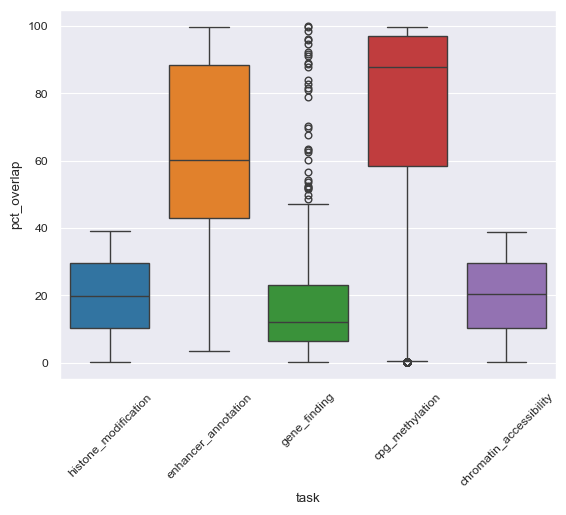

In [23]:
sns.set_style("darkgrid")
sns.set_context("paper")

sns.boxplot(x=overlaps["task"], y=overlaps["pct_overlap"], hue=overlaps["task"])
plt.xticks(rotation=45)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'histone_modification'),
  Text(1, 0, 'enhancer_annotation'),
  Text(2, 0, 'gene_finding'),
  Text(3, 0, 'cpg_methylation'),
  Text(4, 0, 'chromatin_accessibility')])

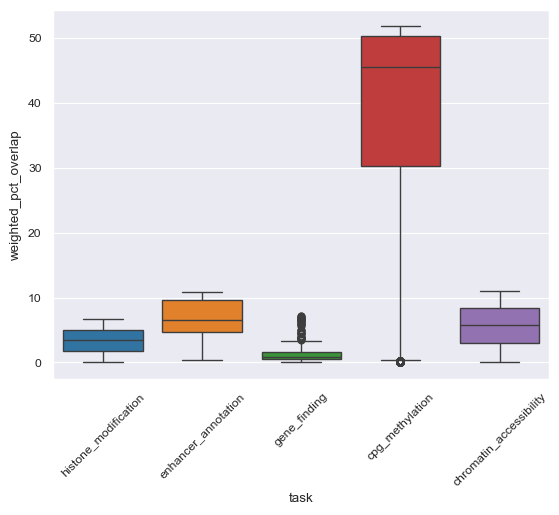

In [24]:
sns.boxplot(x=overlaps["task"], y=overlaps["weighted_pct_overlap"], hue=overlaps["task"])
plt.xticks(rotation=45)